In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

import torchvision

In [2]:
IMG_FOLDER = "data"

### hyperparameters

In [3]:
batch_size = 128 
learning_rate = 0.0002
beta_momentum = 0.5
gen_out_shape = 64
epochs = 10

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device : ", device)

device :  cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize(gen_out_shape),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_loader = datasets.ImageFolder(IMG_FOLDER,transform=transform)
print("dataset size : ", len(data_loader))

dataset size :  135610


In [6]:
data_loader = torch.utils.data.DataLoader(data_loader,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True
                                         )

In [7]:
len(data_loader)

1059

In [8]:
data = iter(data_loader)
images, label = data.next()

In [9]:
print(label)
grid = torchvision.utils.make_grid(images[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [10]:
def plot_image(inp, title=None): 
    inp = np.transpose(inp, axes=[1, 2, 0])
    plt.title(title)
    plt.imshow(inp)
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


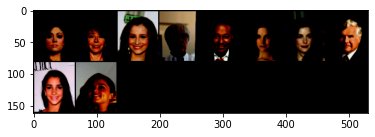

In [11]:
plot_image(grid)

In [32]:
def custom_init(m): 
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d): 
        nn.init.normal_(m.weight, mean=0.0, std=0.02)


In [33]:
import torch.nn.functional as F_

class Generator(nn.Module): 
    
    def __init__(self, ns, output_size): 
        super(Generator, self).__init__()
        self.ns = ns 
        self.output_size = output_size
        self.upconv1 = nn.ConvTranspose2d(ns, 1024, 4, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.upconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.upconv5 = nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(3)
    
    def forward(self, x): 
        x = F_.relu(self.bn1(self.upconv1(x)))
        x = F_.relu(self.bn2(self.upconv2(x)))
        x = F_.relu(self.bn3(self.upconv3(x)))
        x = F_.relu(self.bn4(self.upconv4(x)))
        x = self.bn5(self.upconv5(x))
        x = torch.tanh(x)
        
        return x

In [34]:
# summary 
from torchsummary import summary

generator = Generator(100, gen_out_shape)
generator.to(device)
summary(generator, input_size=(100,1, 1), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2            [1, 1024, 4, 4]           2,048
   ConvTranspose2d-3             [1, 512, 8, 8]       8,388,608
       BatchNorm2d-4             [1, 512, 8, 8]           1,024
   ConvTranspose2d-5           [1, 256, 16, 16]       2,097,152
       BatchNorm2d-6           [1, 256, 16, 16]             512
   ConvTranspose2d-7           [1, 128, 32, 32]         524,288
       BatchNorm2d-8           [1, 128, 32, 32]             256
   ConvTranspose2d-9             [1, 3, 64, 64]           6,144
      BatchNorm2d-10             [1, 3, 64, 64]               6
Total params: 12,658,438
Trainable params: 12,658,438
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 3.94
Params size (MB): 48.29
Esti

In [35]:

class Discriminator(nn.Module): 
    
    def __init__(self, input_size): 
        super(Discriminator, self).__init__()
        self.input_size = input_size 
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(1024)
        
        self.fc = nn.Linear(1024*4*4, 1)
        
    def forward(self, x): 
        x = F_.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F_.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F_.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.bn4(self.conv4(x)))
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [36]:
# summary 

discriminator = Discriminator(gen_out_shape)
discriminator.to(device)
summary(discriminator, input_size=(3,gen_out_shape, gen_out_shape), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 128, 32, 32]           6,272
       BatchNorm2d-2           [1, 128, 32, 32]             256
            Conv2d-3           [1, 256, 16, 16]         524,544
       BatchNorm2d-4           [1, 256, 16, 16]             512
            Conv2d-5             [1, 512, 8, 8]       2,097,664
       BatchNorm2d-6             [1, 512, 8, 8]           1,024
            Conv2d-7            [1, 1024, 4, 4]       8,389,632
       BatchNorm2d-8            [1, 1024, 4, 4]           2,048
            Linear-9                     [1, 1]          16,385
Total params: 11,038,337
Trainable params: 11,038,337
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.75
Params size (MB): 42.11
Estimated Total Size (MB): 45.90
-----------------------------------

### Optimization

In [37]:
g_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_momentum, 0.99))
d_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_momentum, 0.99))
criterion = nn.BCELoss()


### Training loop

In [38]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/dcgan_weight_init')

writer.add_graph(discriminator, images.to(device))
writer.add_graph(generator, torch.randn(128, 100, 1, 1, device="cuda"))


In [39]:
# apply weight init 

discriminator.apply(custom_init)
generator.apply(custom_init)

Generator(
  (upconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
g_train_loss = 0.0
d_train_loss = 0.0
for epoch in range(epochs): 
    for i, pdata in enumerate(data_loader): 
        
        discriminator.zero_grad()
        # classify true labels 
        inputs, _ = pdata 
        inputs = inputs.to(device) # gpu
        
        true_label = torch.full((inputs.shape[0],1), 1.0, dtype=torch.float32, device=device) 
        d_out = discriminator(inputs) 
        # compute loss d loss
        true_loss = criterion(d_out, true_label) 
        # compute grad 
        true_loss.backward() 
        
        # same but with generated images now 
        noise = torch.randn(inputs.shape[0], 100, 1, 1).to(device)
        fake_labels = true_label.fill_(0.0)
        g_out = generator(noise)
        
        # compute loss again 
        fake_loss = criterion(discriminator(g_out.detach()), fake_labels)
        
        # compute grad 
        fake_loss.backward() # IMPORTANT : .backward on the same loss accumulate the function by addition
        d_loss = fake_loss + true_loss
        # update D model 
        d_optim.step() 
        
        # training the generator <=> max log(D(G(x))) <=> we use y = 1 
        generator.zero_grad()
        dgx = discriminator(g_out.detach()) 
        true_label = fake_labels.fill_(1.0) 
        # compute loss 
        g_loss = criterion(dgx, true_label) 
        # compute gradient
        g_loss.backward()
        # update G model 
        g_optim.step()
        
        
        g_train_loss += g_loss 
        d_train_loss += d_loss
        
        if i % 30 == 0: 
            writer.add_scalar('discriminator_loss',
                            d_train_loss / 30,
                            epoch * len(data_loader) + i)
            
            writer.add_scalar('generator_loss',
                            g_train_loss / 30,
                            epoch * len(data_loader) + i)

            print(f"EPOCH : {epoch} | BATCH : {i}/{len(data_loader)} | G LOSS : {g_train_loss/30} | D LOSS : {d_train_loss/30}")
            g_train_loss = 0.0 
            d_train_loss = 0.0
            

EPOCH : 0 | BATCH : 0/1059 | G LOSS : 0.006354441866278648 | D LOSS : 0.046283215284347534
EPOCH : 0 | BATCH : 30/1059 | G LOSS : 0.826266348361969 | D LOSS : 1.2189955711364746
EPOCH : 0 | BATCH : 60/1059 | G LOSS : 0.9773796796798706 | D LOSS : 0.9800807237625122
EPOCH : 0 | BATCH : 90/1059 | G LOSS : 1.122431993484497 | D LOSS : 0.8169804811477661
EPOCH : 0 | BATCH : 120/1059 | G LOSS : 1.2843190431594849 | D LOSS : 0.6594189405441284
EPOCH : 0 | BATCH : 150/1059 | G LOSS : 1.4779210090637207 | D LOSS : 0.5318254232406616
EPOCH : 0 | BATCH : 180/1059 | G LOSS : 1.7029703855514526 | D LOSS : 0.4080401360988617
EPOCH : 0 | BATCH : 210/1059 | G LOSS : 1.9573142528533936 | D LOSS : 0.3092975914478302
EPOCH : 0 | BATCH : 240/1059 | G LOSS : 2.2276244163513184 | D LOSS : 0.23172275722026825
EPOCH : 0 | BATCH : 270/1059 | G LOSS : 2.508124589920044 | D LOSS : 0.17239458858966827
EPOCH : 0 | BATCH : 300/1059 | G LOSS : 2.790156364440918 | D LOSS : 0.12876494228839874
